## Reproductible forecasting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import jmstate
from jmstate import MultiStateJointModel
from jmstate.jobs import *
from jmstate.typedefs import *
from jmstate.utils import *
from uniformbands import get_bands

In [2]:
torch.manual_seed(0)
sigmoid = jmstate.functions.sigmoid

def f(gamma, x, b):
    psi = gamma + b
    psi[..., 1].exp_()
    return psi

In [3]:
lmda, k = 6, 2
gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.diag(torch.tensor([1.0, 0.1, 1.0]))
Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R = torch.tensor([[1.1]])
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)

alphas = {(0, 1): torch.tensor([.4])}
betas = {(0, 1): torch.tensor([-0.9, 0.8, .2])}

real_params = ModelParams(
    gamma,
    repr_from_cov(Q, method="diag"),
    repr_from_cov(R, method="ball"),
    alphas,
    betas
)

In [4]:
weibull_fn = jmstate.functions.Weibull(k, lmda)
surv = {(0, 1): HazardFns(weibull_fn, sigmoid)}
model_design = ModelDesign(f, sigmoid, surv)
real_model = MultiStateJointModel(model_design, real_params)

n, p = 500, 3
t = torch.linspace(0, 15, 15)
c = torch.rand(n, 1) * 5 + 10
x = torch.randn(n, p)

b = Q_dist.sample((n,))
psi = f(gamma, x, b)

trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c.view(-1, 1))

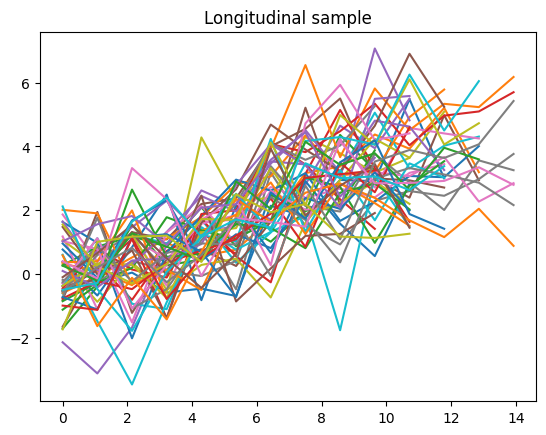

In [5]:
y = model_design.regression_fn(t, psi).squeeze(0)
y += R_dist.sample(y.shape[:2])
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan

plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.show()

Running joint model: 100%|██████████| 250/250 [00:03<00:00, 73.56it/s]


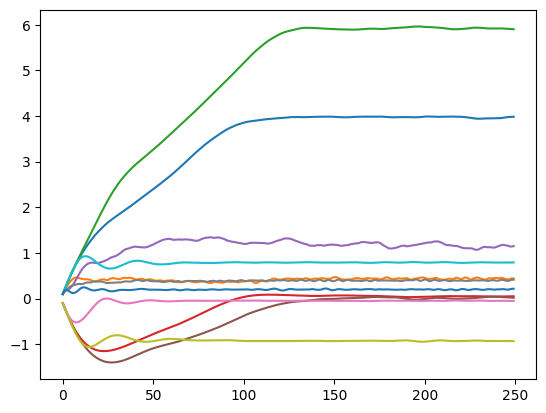

In [6]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    repr_from_cov(torch.eye(Q.size(0)), method="diag"),
    repr_from_cov(torch.eye(R.size(0)), method="full"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

model = MultiStateJointModel(model_design, init_params)

data = ModelData(
    x, t, y, trajectories, c
)

metrics = model.do(data, jobs=[RandomFit(lr=0.1), LogParamsHistory()], max_iterations=250)

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [7]:
model.do(jobs=jmstate.jobs.ComputeFIM())


Running joint model: 100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


namespace(params_history=[ModelParams(gamma=tensor([0.1000, 0.1000, 0.1000]), Q_repr=MatRepr(flat=tensor([-0.1000,  0.1000, -0.1000]), dim=3, method='diag'), R_repr=MatRepr(flat=tensor([-0.1000]), dim=1, method='full'), alphas={(0, 1): tensor([0.1000])}, betas={(0, 1): tensor([-0.1000,  0.1000,  0.1000])}),
                          ModelParams(gamma=tensor([0.1988, 0.1808, 0.1985]), Q_repr=MatRepr(flat=tensor([-0.1984,  0.1580, -0.1993]), dim=3, method='diag'), R_repr=MatRepr(flat=tensor([-0.1970]), dim=1, method='full'), alphas={(0, 1): tensor([0.1503])}, betas={(0, 1): tensor([-0.1999,  0.1998,  0.1751])}),
                          ModelParams(gamma=tensor([0.2953, 0.2494, 0.2951]), Q_repr=MatRepr(flat=tensor([-0.2939,  0.1834, -0.2969]), dim=3, method='diag'), R_repr=MatRepr(flat=tensor([-0.2872]), dim=1, method='full'), alphas={(0, 1): tensor([0.1829])}, betas={(0, 1): tensor([-0.2989,  0.2985,  0.1917])}),
                          ModelParams(gamma=tensor([0.3889, 0.3159, 0.389

In [8]:
n_test = 100
x_test = torch.randn(n_test, p).expand(n_test, p)
b_test = Q_dist.sample((n_test,))
psi_test = f(gamma, None, b_test).expand(n_test, 3)
trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]
y_test = model_design.regression_fn(t, psi_test[[0]])
y_test += R_dist.sample(y_test.shape[:-1])
y_test = y_test.expand(100, *y_test.shape[1:])

real_model = MultiStateJointModel(model_design, real_params)

Running joint model: 100%|██████████| 100/100 [00:01<00:00, 68.27it/s]


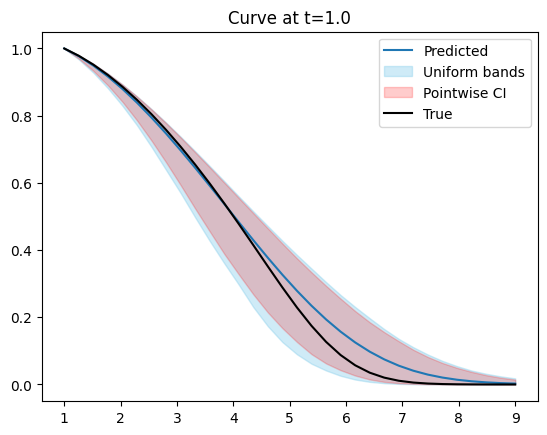

Running joint model: 100%|██████████| 100/100 [00:01<00:00, 61.45it/s]


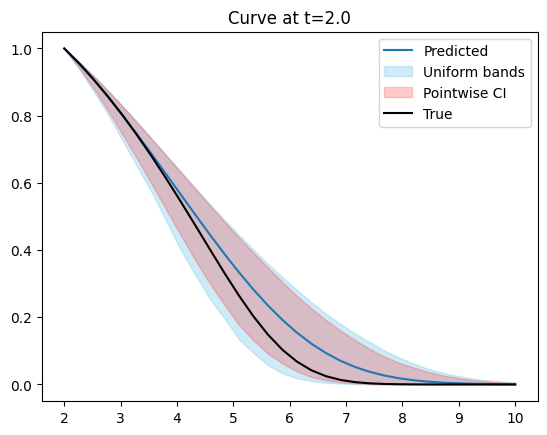

Running joint model: 100%|██████████| 100/100 [00:02<00:00, 41.48it/s]


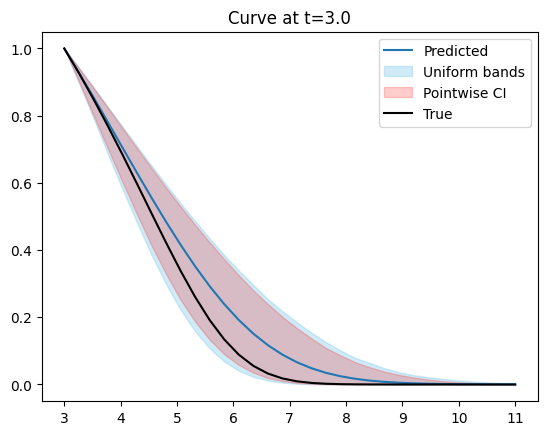

Running joint model: 100%|██████████| 100/100 [00:02<00:00, 40.07it/s]


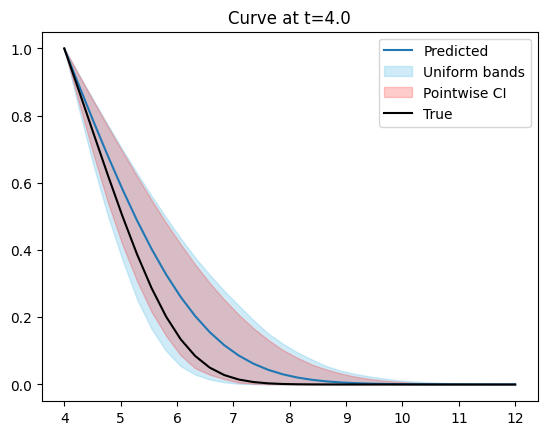

In [ ]:
prediction_times = torch.linspace(1.0, 4.0, 4)
u_grid = torch.linspace(0, 8, 32)

logps_true = []
for time in prediction_times:
    c_test = torch.full((n_test,), time).view(-1, 1)
    sample_test_data = SampleData(x_test, trajectories_init_test, psi_test, c_test)
    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_true.append(real_model.compute_surv_logps(sample_test_data, u))

uniform_coverage = []
pointwise_coverage = []

for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time).view(-1, 1)

    pred_test_data = ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )

    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_pred = real_model.do(pred_test_data, jobs=[jmstate.jobs.PredictSurvLogps(u)])
    logps_pred = torch.cat([d.unsqueeze(0) for d in logps_pred], dim=0)
    logps_pred = logps_pred.permute((1, 0, 2))

    uniform_covered_count = 0
    pointwise_covered_count = 0

    true_prob = torch.exp(logps_true[i]).numpy()
    pred_probs = torch.exp(logps_pred).numpy()

    bands = get_bands(pred_probs)
    pointwise = np.quantile(pred_probs, [0.025, 0.975], axis=1)

    uniform_covered_count += np.all((true_prob >= bands["lower"]) & (true_prob <= bands["upper"]), axis=1).mean()
    pointwise_covered_count += np.all((true_prob >= pointwise[0]) & (true_prob <= pointwise[1]), axis=1).mean()

    points = time + u_grid
    plt.plot(points, pred_probs[0].mean(axis=0), label="Predicted")
    plt.fill_between(points, bands["lower"][0], bands["upper"][0], color="skyblue", alpha=0.4, label="Uniform bands")
    plt.fill_between(points, pointwise[0, 0], pointwise[1, 0], color="red", alpha=0.2, label="Pointwise CI")
    plt.plot(points, true_prob[0], label="True", color="black")
    plt.title(f"Curve at t={time:.1f}")
    plt.legend()
    plt.show()

    uniform_coverage.append(uniform_covered_count)
    pointwise_coverage.append(pointwise_covered_count)



Running joint model: 100%|██████████| 100/100 [00:01<00:00, 93.87it/s]


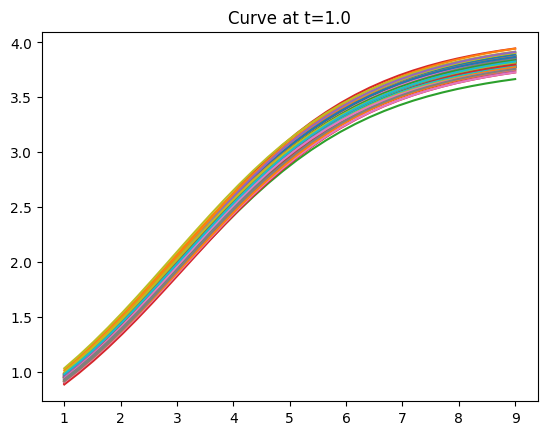

Running joint model: 100%|██████████| 100/100 [00:01<00:00, 89.26it/s]


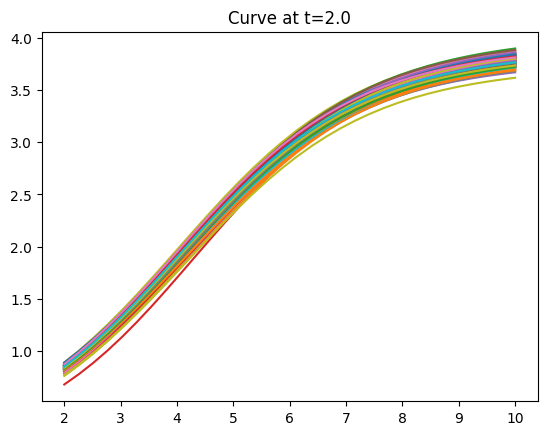

Running joint model: 100%|██████████| 100/100 [00:01<00:00, 50.75it/s]


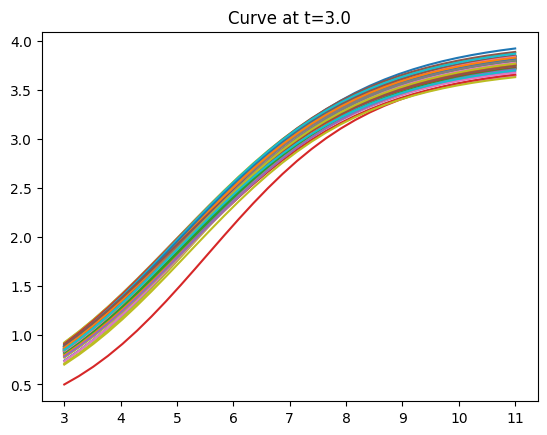

Running joint model: 100%|██████████| 100/100 [00:00<00:00, 173.94it/s]


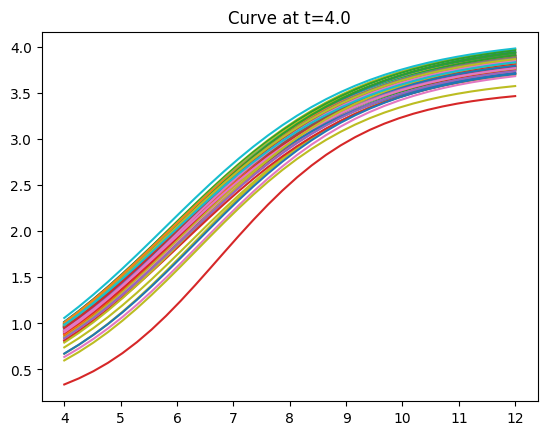

In [10]:
for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time).view(-1, 1)

    pred_test_data = ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )
    y_pr = torch.cat(real_model.do(pred_test_data, jobs=jmstate.jobs.PredictY(u)), dim=2)
    points = time + u_grid
    plt.plot(points, y_pr.mean(dim=2).T)
    plt.title(f"Curve at t={time:.1f}")
    plt.show()